## Introduction: Business Problem

The project will be used to know the safest place in the London base on the total crimes, explore the neighborhoods of that borough 10 most common venues. We decided to use k-means clustering as one of the common machine learning method to solve the issue.

The report will be used to the person who wants to move to London since the safety is the most important aspect to consider when moving to specific location. We will show crime statistic as the basic and main aspect to explain safety issue.

We would focus on the safest place and the most 10 common venues in each neighborhood so that people could consider the best neighborhood which suites to their need. 

## Data

Based on the problem, here's the step to solve the issue:
1. Step 1: Data preprocessing using Kaggle Dataset regarding "London Crimes from 2008 to 2016"
2. Step 2: Web scraping using Beautifulsoup library to get additional information regarding diffrentiation of Boroughs in London from Wikipedia 
3. Step 3: Create a new dataset of the neighboorhoods of the safest place in London, we will use google maps API to get the coordinate information

### Part 1: Data preprocessing using Kaggle Dataset regarding "London Crimes from 2018 to 2016"

Data set URL can be seen below:
https://www.kaggle.com/jboysen/london-crime

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


#### Foursquare credential

In [ ]:
CLIENT_ID = 'R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K' # your Foursquare ID
CLIENT_SECRET = '4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [8]:
# Read the dataset
df = pd.read_csv("C:/Users/rizqi/OneDrive/Documents/Data Science/Telkom Data Science/london_crime_by_lsoa.csv")

In [10]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


#### accessing crime data set in 2015

In [11]:
# Taking only the most recent year (2015) and dropping the rest
df.drop(df.index[df['year'] != 2015], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [12]:
df.shape

(381859, 7)

In [13]:
df.head()


,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01033083,Hounslow,Violence Against the Person,Wounding/GBH,2,2015,8
1,E01002641,Hounslow,Violence Against the Person,Offensive Weapon,1,2015,10
2,E01002873,Kensington and Chelsea,Robbery,Personal Property,1,2015,7
3,E01003790,Redbridge,Violence Against the Person,Assault with Injury,2,2015,12
4,E01000386,Bexley,Violence Against the Person,Assault with Injury,1,2015,6


In [14]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01033083,Hounslow,Violence Against the Person,Wounding/GBH,2,2015,8
1,E01002641,Hounslow,Violence Against the Person,Offensive Weapon,1,2015,10
2,E01002873,Kensington and Chelsea,Robbery,Personal Property,1,2015,7
3,E01003790,Redbridge,Violence Against the Person,Assault with Injury,2,2015,12
4,E01000386,Bexley,Violence Against the Person,Assault with Injury,1,2015,6


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381859 entries, 0 to 381858
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   LSOA_Code       381859 non-null  object
 1   Borough         381859 non-null  object
 2   Major_Category  381859 non-null  object
 3   Minor_Category  381859 non-null  object
 4   No_of_Crimes    381859 non-null  int64 
 5   Year            381859 non-null  int64 
 6   Month           381859 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 20.4+ MB


#### number of crimes in each borough

In [16]:
df['Borough'].value_counts()

Lambeth                   17133
Southwark                 16077
Croydon                   15826
Newham                    15070
Tower Hamlets             14821
Ealing                    14794
Barnet                    14588
Brent                     14457
Lewisham                  14164
Hackney                   13927
Haringey                  13432
Enfield                   13302
Islington                 13146
Wandsworth                13117
Westminster               12808
Camden                    12694
Waltham Forest            12189
Bromley                   12162
Hillingdon                12137
Greenwich                 12070
Hounslow                  11929
Redbridge                 11382
Hammersmith and Fulham    10104
Barking and Dagenham       9498
Kensington and Chelsea     9305
Havering                   9192
Harrow                     7981
Merton                     7844
Bexley                     7809
Richmond upon Thames       6869
Sutton                     6750
Kingston

In [17]:
#Total crimes per major category
df['Major_Category'].value_counts()

Theft and Handling             123977
Violence Against the Person    118469
Criminal Damage                 47936
Burglary                        44196
Drugs                           22271
Robbery                         14524
Other Notifiable Offences       10486
Name: Major_Category, dtype: int64

In [18]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham         1629            1822   944   
Barnet                       3853            2252   809   
Bexley                       1085            1565   678   
Brent                        2701            2128  1808   
Bromley                      2524            2295   870   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       333     553               5177   
Barnet                                     389     624               9204   
Bexley                                     387     171               4165   
Brent                                      411     883               8467   
Bromley                                    404     363               7573   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        5888  
Barnet                                      6905  
Bexley                                      3939  
Brent                                       8485  
Bromley                                     6608

In [19]:
# Reset the index
London_crime.reset_index(inplace = True)

In [20]:
# Total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(33)

Borough No_of_Crimes                        \
Major_Category                             Burglary Criminal Damage Drugs   
0                 Barking and Dagenham         1629            1822   944   
1                               Barnet         3853            2252   809   
2                               Bexley         1085            1565   678   
3                                Brent         2701            2128  1808   
4                              Bromley         2524            2295   870   
5                               Camden         2830            1896  1682   
6                       City of London            5               3     6   
7                              Croydon         2718            3113  1568   
8                               Ealing         2630            2474  1410   
9                              Enfield         2809            2126  1231   
10                           Greenwich         1864            2281   945   
11                             Hackney         2514            2033  1317   
12              Hammersmith and Fulham         1571            1471  1416   
13                            Haringey         2568            2141  1335   
14                              Harrow         1671            1180   623   
15                            Havering         1940            1660   705   
16                          Hillingdon         2216            2313  1103   
17                            Hounslow         1780            2164  1097   
18                           Islington         2349            1981  1386   
19              Kensington and Chelsea         1590            1053  1026   
20                Kingston upon Thames          927            1028   901   
21                             Lambeth         2569            2692  2652   
22                            Lewisham         2146            2466  1595   
23                              Merton         1428            1425   476   
24                              Newham         2274            2397  1682   
25                           Redbridge         2245            1627  1272   
26                Richmond upon Thames         1451            1074   396   
27                           Southwark         2991            2572  2272   
28                              Sutton         1279            1321   500   
29                       Tower Hamlets         2560            2426  1812   
30                      Waltham Forest         2230            1987  1448   
31                          Wandsworth         2390            1928   718   
32                         Westminster         3152            2082  2102   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    333     553               5177   
1                                    389     624               9204   
2                                    387     171               4165   
3                                    411     883               8467   
4                                    404     363               7573   
5                                    438    1030              14455   
6                                      0       5                104   
7                                    579     729               9502   
8                                    547     636               9603   
9                                    427     939               7827   
10                                   513     464               7106   
11                                   469    1043              11124   
12                                   421     357               8956   
13                                   445    1235               9368   
14                                   207     311               4411   
15                                   359     323               5850   
16                                  1008     322         

In [21]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,1629,1822,944,333,553,5177,5888,16346
1,Barnet,3853,2252,809,389,624,9204,6905,24036
2,Bexley,1085,1565,678,387,171,4165,3939,11990
3,Brent,2701,2128,1808,411,883,8467,8485,24883
4,Bromley,2524,2295,870,404,363,7573,6608,20637


In [83]:
London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,1629,1822,944,333,553,5177,5888,16346
1,Barnet,3853,2252,809,389,624,9204,6905,24036
2,Bexley,1085,1565,678,387,171,4165,3939,11990
3,Brent,2701,2128,1808,411,883,8467,8485,24883
4,Bromley,2524,2295,870,404,363,7573,6608,20637
5,Camden,2830,1896,1682,438,1030,14455,7146,29477
6,City of London,5,3,6,0,5,104,28,151
7,Croydon,2718,3113,1568,579,729,9502,9880,28089
8,Ealing,2630,2474,1410,547,636,9603,8947,26247
9,Enfield,2809,2126,1231,427,939,7827,6717,22076


In [23]:
London_crime.shape

(33, 9)

#### Step 2: Web scraping using Beautifulsoup library to get additional information regarding diffrentiation of Boroughs in London from Wikipedia

In [24]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"YFLSA@JUeBlDFBC283J36gAAAE4","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":997329509,"wgRevisionId":997329509,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinat

In [26]:
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2019 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

In [27]:
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


#### there is an additional Borough, the name is City of Londong

In [28]:
# Read in the second table 
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,9721,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


#### Append the data frame together

In [29]:
# A continuous index value will be maintained 
# across the rows in the new appended data frame. 

London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map,Population (2013 est)[1]
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906.0,".mw-parser-output .geo-default,.mw-parser-outp...",25,NaN
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31,NaN
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,NaN
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12,NaN
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20,NaN


In [30]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map,Population (2013 est)[1]
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,324745.0,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8,NaN
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,276983.0,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28,NaN
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,329677.0,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5,NaN
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,261317.0,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2,NaN
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,NaN,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1,9721.0


In [31]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2019 est)[1]  32 non-null     float64
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
 10  Population (2013 est)[1]  1 non-null      float64
dtypes: float64(3), int64(1), object(7)
memory usage: 3.0+ KB


#### Removing unnecessary string in the data set

In [32]:

London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map,Population (2013 est)[1]
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906.0,".mw-parser-output .geo-default,.mw-parser-outp...",25,NaN
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31,NaN
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,NaN
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12,NaN
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20,NaN


In [33]:
# Shape of the data frame
London_table.shape

(33, 11)

#### check whether the data frames are match or not

In [34]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

#### according to the result above, 3 data is not match due to unnecessary symbol []

#### We have to find the index of boroughts that didn't match

In [35]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


In [84]:
# change the borough names
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'


In [85]:
#check whether the data frames are correct or not
set(df.Borough) - set(London_table.Borough)

set()

#### merge all data together

In [38]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map,Population (2013 est)[1]
0,Barking and Dagenham,1629,1822,944,333,553,5177,5888,16346,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906.0,".mw-parser-output .geo-default,.mw-parser-outp...",25,NaN
1,Barnet,3853,2252,809,389,624,9204,6905,24036,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31,NaN
2,Bexley,1085,1565,678,387,171,4165,3939,11990,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,NaN
3,Brent,2701,2128,1808,411,883,8467,8485,24883,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12,NaN
4,Bromley,2524,2295,870,404,363,7573,6608,20637,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20,NaN
5,Camden,2830,1896,1682,438,1030,14455,7146,29477,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,270029.0,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11,NaN
6,City of London,5,3,6,0,5,104,28,151,([],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,NaN,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1,9721.0
7,Croydon,2718,3113,1568,579,729,9502,9880,28089,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,386710.0,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19,NaN
8,Ealing,2630,2474,1410,547,636,9603,8947,26247,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,341806.0,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13,NaN
9,Enfield,2809,2126,1231,427,939,7827,6717,22076,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,333794.0,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30,NaN


In [39]:
Ld_crime.shape

(33, 19)

In [40]:
set(df.Borough) - set(Ld_crime.Borough)

set()

In [41]:
# List of Column names of the data frame 
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2019 est)[1]',
 'Co-ordinates',
 'Nr. in map',
 'Population (2013 est)[1]']

In [44]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,NaN,".mw-parser-output .geo-default,.mw-parser-outp...",1629,1822,944,333,553,5177,5888,16346
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,NaN,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,3853,2252,809,389,624,9204,6905,24036
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,NaN,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1085,1565,678,387,171,4165,3939,11990
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,NaN,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,2701,2128,1808,411,883,8467,8485,24883
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,NaN,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,2524,2295,870,404,363,7573,6608,20637
5,Camden,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,NaN,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,2830,1896,1682,438,1030,14455,7146,29477
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,9721.0,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,5,3,6,0,5,104,28,151
7,Croydon,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,NaN,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,2718,3113,1568,579,729,9502,9880,28089
8,Ealing,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,NaN,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,2630,2474,1410,547,636,9603,8947,26247
9,Enfield,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,NaN,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,2809,2126,1231,427,939,7827,6717,22076


### Step 3: Create a new dataset of the neighboorhoods of the safest place in London, we will use google maps API to get the coordinate information

1. Exploration: focus & visualize on the safest place and the most 10 common venues in each neighborhood so that people could consider the best neighborhood which suites to their need.
2. Modelling: will be used K - Means clustering method as unsupervised machine learning algorithm. In this case, we will create cluster & neighborhood.

In [45]:
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,2136.030303,1908.363636,1205.606061,431.181818,647.969697,8606.727273,6628.484848,21564.363636
std,743.587482,609.458972,572.721078,184.367916,406.333875,4686.355622,2385.072956,8605.496648
min,5.000000,3.000000,6.000000,0.000000,5.000000,104.000000,28.000000,151.000000
25%,1629.000000,1565.000000,809.000000,359.000000,323.000000,5850.000000,5033.000000,16346.000000
50%,2245.000000,2033.000000,1231.000000,421.000000,624.000000,8467.000000,6924.000000,22076.000000
75%,2569.000000,2295.000000,1568.000000,513.000000,979.000000,10143.000000,8441.000000,26941.000000
max,3853.000000,3113.000000,2652.000000,1008.000000,1497.000000,27980.000000,10491.000000,47395.000000


In [46]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.1.3


In [47]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

# let's check the column labels types now
all(isinstance(column, str) for column in Ld_crime.columns)


True

In [48]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,NaN,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,3152,2082,2102,726,1497,27980,9856,47395
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,NaN,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,2569,2692,2652,639,1158,12963,10491,33164
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,NaN,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,2991,2572,2272,471,1220,11855,8879,30260
5,Camden,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,NaN,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,2830,1896,1682,438,1030,14455,7146,29477
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,NaN,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,2274,2397,1682,630,1399,11421,9414,29217


#### sort by the biggest 5 number of crimes

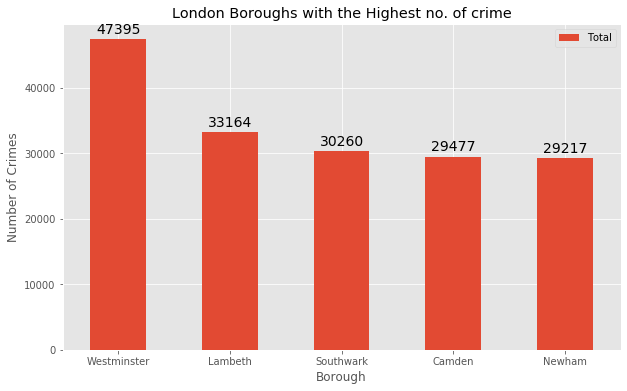

In [49]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

#### sort by the lowest 5 number of crimes

In [50]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,9721.0,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,5,3,6,0,5,104,28,151
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,NaN,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,927,1028,901,201,109,3558,3014,9738
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,NaN,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,1451,1074,396,217,149,4265,2861,10413
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,NaN,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,1279,1321,500,182,163,3457,3696,10598
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,NaN,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1085,1565,678,387,171,4165,3939,11990


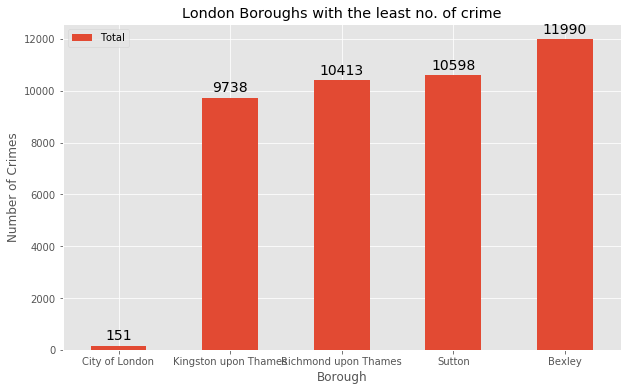

In [51]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

#### the lowest number of crimes is city of london

In [52]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,151,1.12,9721.0


#### Types of crimes visualization in Kingston upon Thames

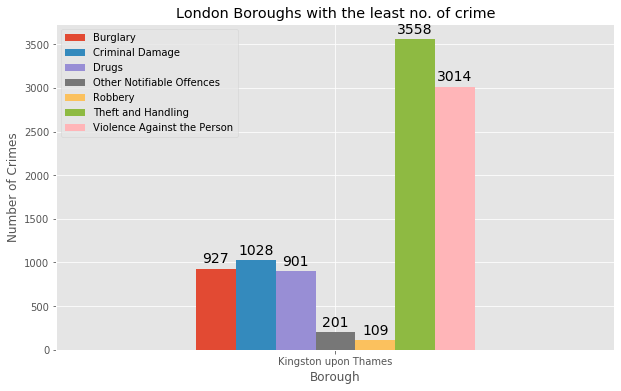

In [53]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

#### create new dataset of the safest borough in Londong

In [54]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


#### Find the coordinates of each neighborhood

In [55]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.417250100000004, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30563059667487563, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [56]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417250,-0.305631
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


In [57]:

address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


#### Maps Visualization

In [58]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

#### Modelling 

1. Find all venues around 500m of each neighborhood
2. Grouping the venues by the neighborhood
3. Use k means with K = 5

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [60]:

kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [61]:
print(kut_venues.shape)
kut_venues.head()

(173, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Canbury,51.417250,-0.305631,Canbury Gardens,51.417409,-0.305300,Park
4,Canbury,51.417250,-0.305631,The Boater's Inn,51.418546,-0.305915,Pub


In [62]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,3,3,3,3,3,3
Canbury,15,15,15,15,15,15
Hook,5,5,5,5,5,5
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,8,8,8,8,8,8
Norbiton,28,28,28,28,28,28


In [63]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))


There are 68 uniques categories.


In [64]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()


,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066667,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Hook,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston upon Thames,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.000000
5,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,New Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Norbiton,0.000000,0.035714,0.035714,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714
9,Old Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000


In [66]:
kut_grouped.shape

(13, 69)

In [67]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                   venue  freq
0   Gym / Fitness Center  0.33
1               Bus Stop  0.33
2                   Park  0.33
3  Portuguese Restaurant  0.00
4                  Plaza  0.00


----Canbury----
                  venue  freq
0                   Pub  0.27
1           Supermarket  0.07
2  Gym / Fitness Center  0.07
3     Fish & Chips Shop  0.07
4                  Park  0.07


----Hook----
               venue  freq
0                Pub   0.2
1             Bakery   0.2
2  Indian Restaurant   0.2
3  Fish & Chips Shop   0.2
4        Supermarket   0.2


----Kingston Vale----
              venue  freq
0     Grocery Store  0.25
1               Bar  0.25
2    Sandwich Place  0.25
3      Soccer Field  0.25
4  Asian Restaurant  0.00


----Kingston upon Thames----
              venue  freq
0       Coffee Shop  0.13
1               Pub  0.07
2  Sushi Restaurant  0.07
3      Burger Joint  0.07
4              Café  0.07


----Malden Rushett----
              venue  freq
0 

#### create data frame of the venues

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [69]:
# display only top 10
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop
1,Canbury,Pub,Park,Fish & Chips Shop,Japanese Restaurant,Supermarket,Spa,Café,Shop & Service,Gym / Fitness Center,Plaza
2,Hook,Indian Restaurant,Pub,Bakery,Supermarket,Fish & Chips Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store
3,Kingston Vale,Grocery Store,Sandwich Place,Bar,Soccer Field,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
4,Kingston upon Thames,Coffee Shop,Café,Pub,Sushi Restaurant,Burger Joint,German Restaurant,Gift Shop,Gym / Fitness Center,Electronics Store,Department Store


#### Clustering with k means

In [70]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 0, 1, 4, 3, 2, 0, 0, 4])

In [71]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,2.0,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop
1,Canbury,Kingston upon Thames,51.417250,-0.305631,0.0,Pub,Park,Fish & Chips Shop,Japanese Restaurant,Supermarket,Spa,Café,Shop & Service,Gym / Fitness Center,Plaza
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hook,Kingston upon Thames,51.367898,-0.307145,0.0,Indian Restaurant,Pub,Bakery,Supermarket,Fish & Chips Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store


In [72]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          13 non-null     float64
 5   1st Most Common Venue   13 non-null     object 
 6   2nd Most Common Venue   13 non-null     object 
 7   3rd Most Common Venue   13 non-null     object 
 8   4th Most Common Venue   13 non-null     object 
 9   5th Most Common Venue   13 non-null     object 
 10  6th Most Common Venue   13 non-null     object 
 11  7th Most Common Venue   13 non-null     object 
 12  8th Most Common Venue   13 non-null     object 
 13  9th Most Common Venue   13 non-null     object 
 14  10th Most Common Venue  13 non-null     obje

In [73]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [74]:
kut_merged.shape

(13, 15)

In [75]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [76]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            13 non-null     object 
 1   Borough                 13 non-null     object 
 2   Latitude                13 non-null     float64
 3   Longitude               13 non-null     float64
 4   Cluster Labels          13 non-null     int32  
 5   1st Most Common Venue   13 non-null     object 
 6   2nd Most Common Venue   13 non-null     object 
 7   3rd Most Common Venue   13 non-null     object 
 8   4th Most Common Venue   13 non-null     object 
 9   5th Most Common Venue   13 non-null     object 
 10  6th Most Common Venue   13 non-null     object 
 11  7th Most Common Venue   13 non-null     object 
 12  8th Most Common Venue   13 non-null     object 
 13  9th Most Common Venue   13 non-null     object 
 14  10th Most Common Venue  13 non-null     obje

#### create map visualization in each cluster

In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

According to the result above, we have:
1. Red cluster as the majority result
2. Blue cluster
3. Purple cluster
4. Orange cluster
5. Green cluster

#### Analysis

We will analyze each cluster to identify the characteristics of each cluster and the neighborhoods of them

In [78]:
#Red cluster
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417250,-0.305631,0,Pub,Park,Fish & Chips Shop,Japanese Restaurant,Supermarket,Spa,Café,Shop & Service,Gym / Fitness Center,Plaza
4,Hook,Kingston upon Thames,51.367898,-0.307145,0,Indian Restaurant,Pub,Bakery,Supermarket,Fish & Chips Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store
9,New Malden,Kingston upon Thames,51.405335,-0.263407,0,Gastropub,Gym,Chinese Restaurant,Sushi Restaurant,Supermarket,Bar,Korean Restaurant,Indian Restaurant,Farmers Market,Department Store
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,0,Food,Italian Restaurant,Pub,Indian Restaurant,Wine Shop,Japanese Restaurant,Hotel,Hardware Store,Fried Chicken Joint,Farmers Market
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,0,Indian Restaurant,Coffee Shop,Pub,Hotel,Pet Café,Chinese Restaurant,Café,Italian Restaurant,Restaurant,Park


Red cluster is the biggest cluster with 9 of 13 neighborhoods in the borough Kingston upon Thames. We can see that the most common venues in these neighborhoods are Pub, Indian Restaurants, Gastropub, park, gym, supermarket, and Food

In [79]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.43185,-0.258138,1,Grocery Store,Sandwich Place,Bar,Soccer Field,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant


Purple cluster has one neighborhood which consists of venues such as restaurant, soccer field, dept. store

In [80]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,2,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,2,Gym,Park,Bus Stop,Soccer Field,Wine Shop,Fast Food Restaurant,Department Store,Dry Cleaner,Electronics Store,Farmers Market


Blue cluster has two neighborhods which consist of venues such as park, gym, bus stop

In [81]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,3,Grocery Store,Pub,Garden Center,Restaurant,Farmers Market,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Fast Food Restaurant


Green cluster has one neighborhood which consists of venues such as restaurant, garden, food.

In [82]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,4,Coffee Shop,Café,Pub,Sushi Restaurant,Burger Joint,German Restaurant,Gift Shop,Gym / Fitness Center,Electronics Store,Department Store
11,Old Malden,Kingston upon Thames,51.382484,-0.259090,4,Coffee Shop,Pub,Food,Construction & Landscaping,Train Station,Bakery,Bar,Gift Shop,German Restaurant,Gastropub
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,4,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Pharmacy,Breakfast Spot,French Restaurant,Train Station,Gym / Fitness Center,Farmers Market
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,4,Grocery Store,Restaurant,Sandwich Place,Train Station,Hotel,Italian Restaurant,Coffee Shop,Pharmacy,Café,Bus Stop


Orange cluster is the second biggest cluster with 4 of 13 neighborhoods in the borough Kingston upon Thames. We can see that the most common venues in these neighborhoods are Pub, Restaurants, Bus Stop, Hotel, and Food